In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing/ setting up data sets

## Import data from tsv and get the sequence length to use for padding

In [2]:
# import data.tsv file and create a dataframe

df = pd.read_csv('data.tsv', sep='\t')

# open file data_info.txt and read the first line

sequence_length = None
with open('data_info.txt', 'r') as f:
    line = f.readline()
    split_line_on_collen = line.split(':')
    sequence_length = int(split_line_on_collen[1])
    

## Split into train and test 

In [3]:

train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

## balance the positive and negative 

In [4]:
train_df_sit_ups = train_df[train_df['Y'] == 1]
train_df_non_sit_ups = train_df[train_df['Y'] == 0]

print(len(train_df_sit_ups))
print(len(train_df_non_sit_ups))

train_df_non_sit_ups_balanced = train_df_non_sit_ups.sample(n=len(train_df_sit_ups), random_state=0)


train_df = pd.concat([train_df_sit_ups, train_df_non_sit_ups_balanced])

test_df_sit_ups = test_df[test_df['Y'] == 1]
test_df_non_sit_ups = test_df[test_df['Y'] == 0]

test_df_non_sit_ups = test_df_non_sit_ups.sample(n=len(test_df_sit_ups), random_state=0)

test_df_balanced = pd.concat([test_df_sit_ups, test_df_non_sit_ups])
test_df = test_df_balanced

508
720


## separate x and y from test and training

In [5]:
train_x = train_df.drop(['Y'], axis=1).iloc[1:]
train_y = train_df['Y'].iloc[1:]

test_x = test_df.drop(['Y'], axis=1)


test_y = test_df['Y']

## Convert the cells in each collumn of the dataframe from string to a numpy array and convert the whole dataframe to numpy array

In [6]:
def convert_rows_to_nupy_array(df):
    numpy_array = []
    for index, row in df.iterrows():
        row_array = []
        for col in row.iteritems():
            col_float = []
            for item in col[1].split(','):
                col_float.append(float(item.replace('[', '').replace(']', '')))
            row_array.append(col_float)
        numpy_array.append(row_array)
    return np.array(numpy_array)

train_x_numpy = convert_rows_to_nupy_array(train_x)
test_x_numpy = convert_rows_to_nupy_array(test_x)
            

##### Remove Padding from numpy and create separate dataset

In [7]:
train_y_no_pad = train_y
test_y_no_pad = test_y

# remove the numpy array where you hava a [0,0,0] array

test_np_array = np.array([[1,2,1], [0,0,0], [1,2,1]])

# remove the [0,0,0] array from the numpy array test_np_array

test_np_array = test_np_array[test_np_array[:,0] != 0]



train_x_numpy_no_pad = []
# row_index = 0
for row in range(len(train_x_numpy)):
    temp = train_x_numpy[row][train_x_numpy[row][:,0] != 0]
    temp_list = []
    for col in temp:
        item_list = []
        for item in col:
            item_list.append(item)
        temp_list.append(item_list)
    train_x_numpy_no_pad.append(temp_list)
train_x_numpy_no_pad = np.array(train_x_numpy_no_pad)

test_x_numpy_no_pad = []
# row_index = 0
for row in range(len(test_x_numpy)):
    temp = test_x_numpy[row][test_x_numpy[row][:,0] != 0]
    temp_list = []
    for col in temp:
        item_list = []
        for item in col:
            item_list.append(item)
        temp_list.append(item_list)
    test_x_numpy_no_pad.append(temp_list)
test_x_numpy_no_pad = np.array(test_x_numpy_no_pad)
print(train_x_numpy_no_pad.shape)


/tmp/ipykernel_5050/2768496912.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_x_numpy_no_pad = np.array(train_x_numpy_no_pad)


(1015,)


/tmp/ipykernel_5050/2768496912.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_x_numpy_no_pad = np.array(test_x_numpy_no_pad)


# Train

## Dummy Classifier

In [8]:
# Dummy Classifer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent")
print(train_x_numpy.shape, train_y.shape)
dummy_clf.fit(train_x_numpy, train_y)
y_pred = dummy_clf.predict(test_x_numpy)
print(accuracy_score(test_y, y_pred))

(1015, 2121, 3) (1015,)
0.5


## Recurrent Neural Classifier

### Dataset loader

In [9]:

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input,target, seq_len):
        self.input = input
        self.target = target
        self.seq_len = seq_len
    def __getitem__(self, item):
        return self.input[item], self.target.iloc[item]

    def __len__(self):
        return  self.input.shape[0]

In [10]:
class MyVariableLengthDataset(torch.utils.data.Dataset):
    def __init__(self, input,target):
        self.input = input
        self.target = target
    def __getitem__(self, item):
        # print("input item", self.input[item])
        return self.input[item], self.target.iloc[item]

        # return input[item:item+self.seq_len], input[item+self.seq_len]
    def __len__(self):
        return self.input.shape[0]

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyper parameters

In [12]:
input_size = 3                                                                           
num_classes = 1
hidden_size = 3
num_layers = 3
learning_rate = 0.001
batch_size = 1
num_epochs = 5
clip = 5

### For testing reduce to certain size

In [13]:
# reduce size of train_x_numpy_no_pad to 1000
# train_x_numpy = train_x_numpy[:50]
# train_y = train_y[:50]

# test_x_numpy = test_x_numpy[:50]
# test_y = test_y[:50]


# print how many 1 and 0 in the train_y
print(train_y.value_counts())

0    508
1    507
Name: Y, dtype: int64


## LSTM Neural Network Archetecture

In [14]:
class SitUpDetector(nn.Module):
    def __init__(self,input_size, num_classes, hidden_size, num_layers,drop_prob=0.5):
        super(SitUpDetector, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        batch_size = x.size(0)
        out, _ = self.lstm(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out,hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().float().to(device),
                      weight.new(self.num_layers, batch_size, self.hidden_size).zero_().float().to(device)) 
        return hidden

## Create Model, Optimizers, dataloader and other variables

In [15]:
model = SitUpDetector(input_size, num_classes, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



myDataset = MyDataset(train_x_numpy,train_y, sequence_length)
train_loader = torch.utils.data.DataLoader(dataset=myDataset, batch_size=batch_size)

losses = []
loss = None
valid_loss_min = np.Inf
total_steps = len(train_loader)


### Train Network

Epoch: 1/5... Step: 49... Loss: 0.544162... Val Loss: 0.707734
losses as np array [0.54416203]
Validation loss decreased (inf --> 0.707734).  Saving model ...
Epoch: 1/5... Step: 99... Loss: 0.514646... Val Loss: 0.716325
losses as np array [0.54416203 0.51464558]
Epoch: 1/5... Step: 149... Loss: 0.483305... Val Loss: 0.730910
losses as np array [0.54416203 0.51464558 0.48330525]
Epoch: 1/5... Step: 199... Loss: 0.429529... Val Loss: 0.760231
losses as np array [0.54416203 0.51464558 0.48330525 0.42952949]
Epoch: 1/5... Step: 249... Loss: 0.454424... Val Loss: 0.810252
losses as np array [0.54416203 0.51464558 0.48330525 0.42952949 0.45442405]
Epoch: 1/5... Step: 299... Loss: 0.441025... Val Loss: 0.870960
losses as np array [0.54416203 0.51464558 0.48330525 0.42952949 0.45442405 0.44102532]
Epoch: 1/5... Step: 349... Loss: 0.249727... Val Loss: 0.936649
losses as np array [0.54416203 0.51464558 0.48330525 0.42952949 0.45442405 0.44102532
 0.24972704]
Epoch: 1/5... Step: 399... Loss: 0

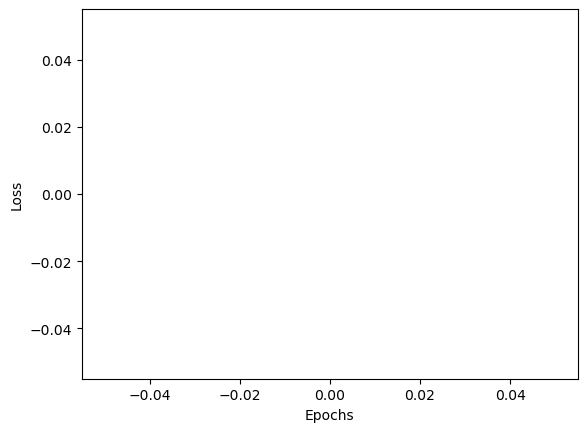

In [16]:

model.train()
for epoch in range(num_epochs):
    h = model.init_hidden(batch_size)
    for i, (features, target) in enumerate(train_loader):

        h = tuple([e.data for e in h])

        features, target = features.to(device), target.to(device)
        model.zero_grad()
        outputs, h = model(features.float(), h)
        loss = criterion(outputs, target.float())
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        loss.backward()

        optimizer.step()
        if (i+1) % 50 == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in train_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp.float(), val_h)
                val_loss = criterion(out, lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(epoch+1, num_epochs),
                  "Step: {}...".format(i),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            losses.append(loss.item())
            # print("why","{:.6f}".format(loss.item().detach().numpy()))


            print("losses as np array",np.array(losses))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

# graph the losses 

# get the lenght of the losses array

# create an array of the same length as the losses array with index values
for i in range(len(losses)):
    if type(losses[i]) == torch.Tensor:
        losses[i] = losses[i].detach().numpy()

y = np.array(losses)
print("plt y shpae loss", y.shape)
# print("y shpae")
# print(y)

x = np.arange(0,len(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()
plt.savefig(f"loss-for-params-num-{num_layers}-learning_rate{learning_rate}.png")
plt.show()


torch.save(model.state_dict(), 'sit_up_detector.pth')


## Test Accuracy

In [17]:
# Check accuracy
test_dataset = MyDataset(train_x_numpy,train_y, sequence_length)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1)
n_correct = 0
n_samples = 0
model.eval()

all_predictions = []


test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)


model.eval()
for inputs, label in train_loader:
    h = tuple([each.data for each in h])
    inputs, label = inputs.to(device), label.to(device)
    output, h = model(inputs.float(), h)
    test_loss = criterion(output, label.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(label.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.726
Test accuracy: 50.049%


# Train with different network with simpler rnn

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
class MyVariableLengthDataset(torch.utils.data.Dataset):
    def __init__(self, input,target):
        self.input = input
        self.target = target
    def __getitem__(self, item):
        # print("input item", self.input[item])
        return self.input[item], self.target.iloc[item]

        # return input[item:item+self.seq_len], input[item+self.seq_len]
    def __len__(self):
        return self.input.shape[0]

In [20]:
input_size = 3
num_classes = 2
hidden_size = 12
learning_rate = 0.001
num_epochs = 100


In [21]:
class SitUpDetectorSimpleRNN(nn.Module):
    def __init__(self,input_size, num_classes, hidden_size):
        super(SitUpDetectorSimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, num_classes)
    

    def forward(self, x, hidden_state):
        combined = torch.cat((x.unsqueeze(0), hidden_state),1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))



model info
SitUpDetectorSimpleRNN(
  (in2hidden): Linear(in_features=15, out_features=12, bias=True)
  (in2output): Linear(in_features=15, out_features=2, bias=True)
)
Epoch [1/100], Loss: 0.0157
Epoch [2/100], Loss: 0.0162
Epoch [3/100], Loss: 0.0161
Epoch [4/100], Loss: 0.0165
Epoch [5/100], Loss: 0.0178
Epoch [6/100], Loss: 0.0207
Epoch [7/100], Loss: 0.0249
Epoch [8/100], Loss: 0.0299
Epoch [9/100], Loss: 0.0353
Epoch [10/100], Loss: 0.0406
Epoch [11/100], Loss: 0.0454
Epoch [12/100], Loss: 0.0496
Epoch [13/100], Loss: 0.0529
Epoch [14/100], Loss: 0.0549
Epoch [15/100], Loss: 0.0555
Epoch [16/100], Loss: 0.0547
Epoch [17/100], Loss: 0.0524
Epoch [18/100], Loss: 0.0494
Epoch [19/100], Loss: 0.0461
Epoch [20/100], Loss: 0.0429
Epoch [21/100], Loss: 0.0399
Epoch [22/100], Loss: 0.0371
Epoch [23/100], Loss: 0.0345
Epoch [24/100], Loss: 0.0322
Epoch [25/100], Loss: 0.0301
Epoch [26/100], Loss: 0.0282
Epoch [27/100], Loss: 0.0265
Epoch [28/100], Loss: 0.0251
Epoch [29/100], Loss: 0.0233


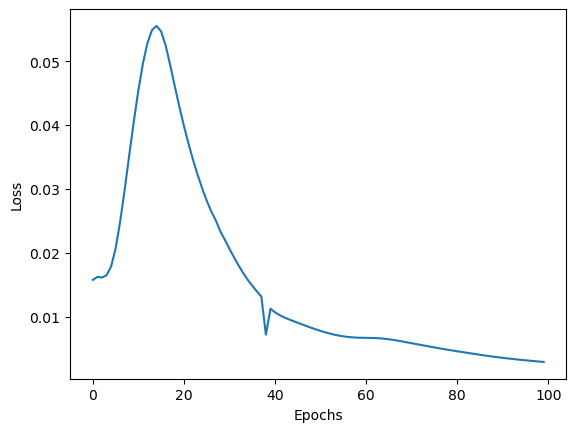

In [22]:
#  create pytorch lstm variable recurrent classifier


# train SitUpDetectorVariableInput
model = SitUpDetectorSimpleRNN(input_size, num_classes, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("model info")
print(model)

myDatasetVariableSequenceLengthDataset = MyVariableLengthDataset(train_x_numpy_no_pad,train_y)
train_loader = torch.utils.data.DataLoader(dataset=myDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

losses = []
loss = None
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, target) in enumerate(train_loader):
        hidden_state = model.init_hidden()
        for xyz in features:
            xyz = torch.tensor(xyz)
            output, hidden_state = model(xyz.float(), hidden_state)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Loss: {loss.item():.4f}"
            )
    losses.append(loss.item())


y = np.array(losses)
x = np.arange(0,len(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x,y)
plt.savefig(f"simple-rnn-loss-for-params-num-{num_layers}-learning_rate{learning_rate}-epochs-{num_epochs}.png")
plt.show()




In [23]:

myTestDatasetVariableSequenceLengthDataset = MyVariableLengthDataset(test_x_numpy_no_pad,test_y)
test_loader = torch.utils.data.DataLoader(dataset=myTestDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

num_correct = 0
num_samples = len(test_loader)

model.eval()

with torch.no_grad():
    for i, (features, target) in enumerate(test_loader):
        hidden_state = model.init_hidden()
        for xyz in features:
            xyz = torch.tensor(xyz)
            output, hidden_state = model(xyz.float(), hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == target)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

# save the accuracy and model hyperparameters to a text file 

with open(f"simple-rnn-accuracy-for-params-num-{num_layers}-learning_rate{learning_rate}-epochs-{num_epochs}.txt", "w") as f:
    f.write(f"Accuracy: {num_correct / num_samples * 100:.4f}%")
    f.write(f"num_layers: {num_layers}")
    f.write(f"learning_rate: {learning_rate}")
    f.write(f"num_epochs: {num_epochs}")
    f.write(f"hidden_size: {hidden_size}")
    f.write(f"input_size: {input_size}")
    f.write(f"num_classes: {num_classes}")
    f.write(f"optimizer: {optimizer}")
    



Accuracy: 49.6032%


## Hyper param tunning

In [24]:
# find the best hyperparameters for the model

import itertools


learning_rates = [0.001, 0.005,0.0005, 0.0001]
num_epochs = [200,400,800]
hidden_sizes = [2,3,6,12, 24, 36, 48]
num_classes = 2
input_size = 3
optimizers = [torch.optim.Adam]
# create a list of all possible combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, num_epochs, hidden_sizes, optimizers))
# create a list to store the accuracy of each combination of hyperparameters
accuracy_list = []
# loop through each combination of hyperparameters

for combination in hyperparameter_combinations:

    # create pytorch lstm variable recurrent classifier
    model = SitUpDetectorSimpleRNN(input_size, num_classes, combination[2]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = combination[3](model.parameters(), lr=combination[0])

    myDatasetVariableSequenceLengthDataset = MyVariableLengthDataset(train_x_numpy_no_pad,train_y)
    train_loader = torch.utils.data.DataLoader(dataset=myDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

    losses = []
    loss = None
    total_steps = len(train_loader)
    for epoch in range(combination[1]):
        for i, (features, target) in enumerate(train_loader):
            hidden_state = model.init_hidden()
            for xyz in features:
                xyz = torch.tensor(xyz)
                output, hidden_state = model(xyz.float(), hidden_state)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
        print(
                f"Epoch [{epoch + 1}/{combination[1]}], "
                f"Loss: {loss.item():.4f}"
                )
        losses.append(loss.item())



    myTestDatasetVariableSequenceLengthDataset = MyVariableLengthDataset(test_x_numpy_no_pad,test_y)
    test_loader = torch.utils.data.DataLoader(dataset=myTestDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

    model.eval()
    myTestDatasetVariableSequenceLengthDataset = MyVariableLengthDataset(test_x_numpy_no_pad,test_y)
    test_loader = torch.utils.data.DataLoader(dataset=myTestDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

    num_correct = 0
    num_samples = len(test_loader)

    model.eval()

    with torch.no_grad():
        for i, (features, target) in enumerate(test_loader):
            hidden_state = model.init_hidden()
            for xyz in features:
                xyz = torch.tensor(xyz)
                output, hidden_state = model(xyz.float(), hidden_state)
            _, pred = torch.max(output, dim=1)
            num_correct += bool(pred == target)

    print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")
    accuracy_list.append(num_correct / num_samples * 100)

# display the best hyperparameters
print(f"Best hyperparameters: {hyperparameter_combinations[accuracy_list.index(max(accuracy_list))]}")


Epoch [1/200], Loss: 0.3636
Epoch [2/200], Loss: 0.3564
Epoch [3/200], Loss: 0.3669
Epoch [4/200], Loss: 0.3791
Epoch [5/200], Loss: 0.3902
Epoch [6/200], Loss: 0.3999
Epoch [7/200], Loss: 0.4085
Epoch [8/200], Loss: 0.4160
Epoch [9/200], Loss: 0.4226
Epoch [10/200], Loss: 0.4286
Epoch [11/200], Loss: 0.4339
Epoch [12/200], Loss: 0.4387
Epoch [13/200], Loss: 0.4431
Epoch [14/200], Loss: 0.4471
Epoch [15/200], Loss: 0.4508
Epoch [16/200], Loss: 0.4543
Epoch [17/200], Loss: 0.4576
Epoch [18/200], Loss: 0.4607
Epoch [19/200], Loss: 0.4637
Epoch [20/200], Loss: 0.4666
Epoch [21/200], Loss: 0.4695
Epoch [22/200], Loss: 0.4723
Epoch [23/200], Loss: 0.4750
Epoch [24/200], Loss: 0.4778
Epoch [25/200], Loss: 0.4805
Epoch [26/200], Loss: 0.4832
Epoch [27/200], Loss: 0.4860
Epoch [28/200], Loss: 0.4887
Epoch [29/200], Loss: 0.4914
Epoch [30/200], Loss: 0.4941
Epoch [31/200], Loss: 0.4967
Epoch [32/200], Loss: 0.4994
Epoch [33/200], Loss: 0.5020
Epoch [34/200], Loss: 0.5047
Epoch [35/200], Loss: 0

KeyboardInterrupt: 

In [26]:
best_hyperparameters = hyperparameter_combinations[accuracy_list.index(max(accuracy_list))]
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best accuracy: {max(accuracy_list)}")

for i in range(len(hyperparameter_combinations)):
    print(f"{hyperparameter_combinations[i]}: {accuracy_list[i]}")


Best hyperparameters: (0.001, 800, 48, <class 'torch.optim.adam.Adam'>)
Best accuracy: 63.888888888888886
(0.001, 200, 2, <class 'torch.optim.adam.Adam'>): 46.82539682539682
(0.001, 200, 3, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 200, 6, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 200, 12, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 200, 24, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 200, 36, <class 'torch.optim.adam.Adam'>): 50.79365079365079
(0.001, 200, 48, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 400, 2, <class 'torch.optim.adam.Adam'>): 49.60317460317461
(0.001, 400, 3, <class 'torch.optim.adam.Adam'>): 49.2063492063492
(0.001, 400, 6, <class 'torch.optim.adam.Adam'>): 50.0
(0.001, 400, 12, <class 'torch.optim.adam.Adam'>): 51.19047619047619
(0.001, 400, 24, <class 'torch.optim.adam.Adam'>): 52.38095238095239
(0.001, 400, 36, <class 'torch.optim.adam.Adam'>): 55.158730158730165
(0.001, 400, 48, <class 'torch.optim.adam.Adam'>): 51.587301587301596
(0.001, 800

IndexError: list index out of range

# Multivariate classifier

### Imports

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
# from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator


from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested
)

### Test with example

In [ ]:
X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()
np.unique(y_train)

steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("score", score)

clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print("score ", score)

## Implement on my data

### convert current dataset to sktime format

In [ ]:
# import data.tsv file and create a dataframe

df = pd.read_csv('data.tsv', sep='\t')

# open file data_info.txt and read the first line

sequence_length = None
with open('data_info.txt', 'r') as f:
    line = f.readline()
    split_line_on_collen = line.split(':')
    sequence_length = int(split_line_on_collen[1])

In [ ]:

train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
train_x = train_df.drop(['Y'], axis=1).iloc[1:]
train_y = train_df['Y'].iloc[1:]
y = train_y.to_numpy()


In [ ]:
def convert_rows_to_nupy_array(df):
    numpy_array = []
    for index, row in df.iterrows():
        row_array = []
        col_x = []
        col_y = []
        col_z = []
        for col in row.iteritems():
            col_float = []
            for item in col[1].split(','):
                col_float.append(float(item.replace('[', '').replace(']', '')))
            col_x.append(col_float[0])   
            col_y.append(col_float[1])
            col_z.append(col_float[2]) 
        row_array.append(col_x)
        row_array.append(col_y)
        row_array.append(col_z)
        numpy_array.append(row_array)
    return np.array(numpy_array)

train_x_numpy = convert_rows_to_nupy_array(train_x)

print(train_x_numpy.shape)

In [ ]:

multivariate_dataframe_train_x = from_3d_numpy_to_nested(train_x_numpy_x_y_z_separate_arrays)
# multivariate_dataframe_test_x = from_3d_numpy_to_nested(multivariate_list_np_test)
print(multivariate_dataframe_train_x.shape)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(multivariate_dataframe_train_x, y, random_state=42)


steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
print("score is", score)


clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5,n_jobs=-1), [2]),
    ]
)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)